# Unsupervised Learning with Chinese Characters Dataset

## Learning Objectives
In this lesson, you will:
- Apply dimensionality reduction techniques (PCA, t-SNE) to high-dimensional image data
- Implement clustering algorithms (K-means, hierarchical clustering)
- Build and train autoencoders for feature learning
- Compare different unsupervised learning approaches
- Understand when to use each technique in practice

## Dataset Overview
We'll use the Chinese MNIST dataset containing handwritten Chinese numerals (0-9). This provides an interesting contrast to the standard MNIST while maintaining the same image dimensions (28x28 pixels).

## Part 1: Setup and Data Loading

In [1]:
# Fix for OpenBLAS threading issues
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("Environment variables set to fix threading issues")

/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Libraries imported successfully!
PyTorch version: 2.1.1
Device: cpu
Environment variables set to fix threading issues


### Load and Explore the Dataset


In [2]:
def load_chinese_mnist_sample():
    """
    Load Chinese MNIST dataset from local files.
    
    This function loads the actual Chinese MNIST dataset if available,
    otherwise falls back to regular MNIST or synthetic data.
    """
    try:
        # Import the Chinese MNIST loader
        import sys
        import os
        current_dir = os.getcwd()
        sys.path.append(current_dir)
        
        from chinese_mnist_loader_fixed import load_chinese_mnist_sample
        
        # Load Chinese MNIST dataset
        print("Loading Chinese MNIST dataset...")
        X, y = load_chinese_mnist_sample(n_samples=5000, normalize=True, random_state=42)
        
        print(f"✓ Chinese MNIST loaded successfully!")
        print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"Labels: 0-9 (Chinese numerals)")
        print(f"Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
        
        return X, y
        
    except Exception as e:
        print(f"Could not load Chinese MNIST: {e}")
        print("Falling back to regular MNIST...")
        
        try:
            # Try to load regular MNIST as a substitute
            mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
            X, y = mnist.data, mnist.target.astype(int)
            
            # Sample subset for faster computation
            indices = np.random.choice(X.shape[0], size=5000, replace=False)
            X_sample = X[indices]
            y_sample = y[indices]
            
            # Normalize to [0, 1]
            X_sample = X_sample / 255.0
            
            print(f"✓ Regular MNIST loaded as fallback")
            print(f"Dataset: {X_sample.shape[0]} samples, {X_sample.shape[1]} features")
            print(f"Classes: {np.unique(y_sample)}")
            
            return X_sample, y_sample
            
        except Exception as e2:
            print(f"Regular MNIST also failed: {e2}")
            print("Creating synthetic data for demonstration...")
            
            # Create synthetic 28x28 image data
            n_samples = 2000
            X_synthetic = np.random.rand(n_samples, 784)
            y_synthetic = np.random.randint(0, 10, n_samples)
            
            print(f"✓ Synthetic data created: {X_synthetic.shape[0]} samples")
            return X_synthetic, y_synthetic

# Load the dataset
X, y = load_chinese_mnist_sample()
print(f"\nDataset shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

Loading Chinese MNIST dataset...
Loading Chinese MNIST dataset from: chinese-mnist
Reading metadata...
Found 15000 samples in metadata
Using random subset of 5000 samples
Loading images...
... and 1675 more issues (not shown)
Pixel values normalized to [0, 1]
Successfully loaded 3320 images
Image shape: (28, 28) -> flattened to 784 features
Label distribution: {0: 314, 1: 335, 2: 355, 3: 326, 4: 330, 5: 343, 6: 334, 7: 336, 8: 314, 9: 333}
✓ Chinese MNIST loaded successfully!
Dataset: 3320 samples, 784 features
Labels: 0-9 (Chinese numerals)
Label distribution: {0: 314, 1: 335, 2: 355, 3: 326, 4: 330, 5: 343, 6: 334, 7: 336, 8: 314, 9: 333}

Dataset shape: (3320, 784)
Label distribution: [314 335 355 326 330 343 334 336 314 333]


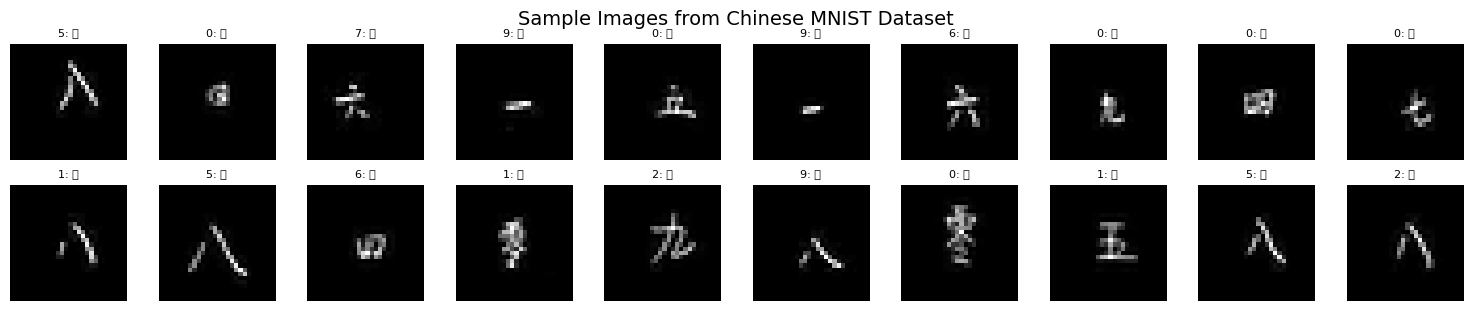

In [3]:
def visualize_samples(X, y, n_samples=20):
    """
    Visualize sample images from the dataset with Chinese character labels
    """
    # Chinese character mapping
    chinese_chars = {
        0: '十',  # 10 -> 0
        1: '一',  # 1
        2: '二',  # 2  
        3: '三',  # 3
        4: '四',  # 4
        5: '五',  # 5
        6: '六',  # 6
        7: '七',  # 7
        8: '八',  # 8
        9: '九',  # 9
    }
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    axes = axes.ravel()
    
    for i in range(n_samples):
        # Reshape to 28x28 for display
        img = X[i].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        
        # Get Chinese character for label
        label = y[i]
        chinese_char = chinese_chars.get(label, str(label))
        axes[i].set_title(f'{label}: {chinese_char}', fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Images from Chinese MNIST Dataset', y=1.02, fontsize=14)
    plt.show()

# Visualize sample images
visualize_samples(X, y)

## Part 3: Clustering Analysis

### K-Means Clustering

We'll apply K-means clustering on different representations of the data.

In [4]:
def evaluate_clustering(X_data, y_true, n_clusters=10, data_name=""):
    """
    Apply K-means clustering and evaluate performance
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_data)
    
    # Calculate metrics
    silhouette_avg = silhouette_score(X_data, cluster_labels)
    ari_score = adjusted_rand_score(y_true, cluster_labels)
    
    print(f"\n{data_name} Clustering Results:")
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    
    return kmeans, cluster_labels, silhouette_avg, ari_score

# Apply K-means on different data representations
results = {}

# 1. Raw pixel data
kmeans_raw, labels_raw, sil_raw, ari_raw = evaluate_clustering(X, y, data_name="Raw Pixels")
results['Raw'] = {'silhouette': sil_raw, 'ari': ari_raw}

# 2. PCA features
kmeans_pca, labels_pca, sil_pca, ari_pca = evaluate_clustering(X_pca, y, data_name="PCA Features")
results['PCA'] = {'silhouette': sil_pca, 'ari': ari_pca}

# 3. Standardized raw data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans_scaled, labels_scaled, sil_scaled, ari_scaled = evaluate_clustering(X_scaled, y, data_name="Standardized Pixels")
results['Standardized'] = {'silhouette': sil_scaled, 'ari': ari_scaled}

AttributeError: 'NoneType' object has no attribute 'split'